In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data/data32710/

ls: cannot access '/home/aistudio/data/data32710/': No such file or directory


In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries
!pip install nibabel -t /home/aistudio/external-libraries
!pip install tqdm -t /home/aistudio/external-libraries
!pip install opencv-python -t /home/aistudio/ecternal-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 102kB 4.1MB/s ta 0:00:011
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 3.3MB 2.1MB/s eta 0:00:01
     |████████████████████████████████| 15.7MB 34.4MB/s eta 0:00:01
     |████████████████████████████████| 40kB 146kB/s  eta 0:00:01
     |████████████████████████████████| 71kB 3.0MB/s eta 0:00:011
ERROR: blackhole 1.0.1 has requirement numpy<=1.19.5, but you'll have numpy 1.21.2 which is incompatible.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 81kB 3.7MB/s eta 0:00:011
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 89.2MB 7.4MB/s eta 0:00:012     |███▊                            | 10.5MB 52.6MB/s eta 0:00:02     |█████                           

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [1]:
import sys 
sys.path.append('/home/aistudio/external-libraries')
import sys
import numpy as np
import nibabel as nib
from util import *
from tqdm import tqdm
import paddle
import cv2
import matplotlib.pyplot as plt

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


创建数据集

In [2]:
import paddle
from paddle.io import Dataset
import nibabel as nib
import os
from util import listdir
import util
from paddle.vision.transforms import Compose,Resize,CenterCrop,Normalize
import paddle
DATA_SIZE = 8751
BATCH_SIZE = 10
data_path = 'work/preprocess/data'
label_path = 'work/preprocess/label'
IMAGE_SIZE = '512X512X*'
CLASS_NUM = 2
train_split_rate = 0.9

class MyDataset(Dataset):
    def __init__(self, num_samples, data_path, label_path,mode='train',train_split_rate=0.9):
        super(MyDataset,self).__init__()
        self.samples = int(num_samples*train_split_rate)
        self.num_use_samples = self.samples if mode=='train' else (num_samples - self.samples)#返回数据集大小
        if mode == 'train':
            self.data_paths = util.listdir(data_path)[:self.num_use_samples]
            self.label_paths = util.listdir(label_path)[:self.num_use_samples]
        else:
            self.data_paths = util.listdir(data_path)[self.num_use_samples:]
            self.label_paths = util.listdir(data_path)[self.num_use_samples:]
        self.transforms = Compose([
    Normalize(mean=[-2.1675715,-2.16623,-2.1652305],std=[1.9515692,1.9533594,1.955353],data_format='CHW'),
        ])
    def __getitem__(self, index):
        image = np.load(os.path.join(data_path,self.data_paths[index]),allow_pickle=True)
        mask = np.load(os.path.join(label_path,self.label_paths[index]),allow_pickle=True)
        image = self.transforms(image)
        return image, mask
    def __len__(self):
        return len(self.label_paths)
train_dataset = MyDataset(DATA_SIZE, data_path, label_path)
test_dataset = MyDataset(DATA_SIZE,data_path,label_path,mode='test')
train_loader = paddle.io.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
test_loader = paddle.io.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=True)


In [3]:
import cv2
def SelfDefineLoss(predict, label, num_classes=2):
    aug_label = []
    for i in label.numpy().astype(np.float32):
        tmp = []
        cur_mask = i[0]
        x = cv2.Sobel(cur_mask,cv2.CV_16S,1,0)
        y = cv2.Sobel(cur_mask,cv2.CV_16S,1,0)
        Scale_absX = cv2.convertScaleAbs(x)
        Scale_absY = cv2.convertScaleAbs(y)
        tmp.append(cv2.addWeighted(Scale_absX, 0.5, Scale_absY,0.5, 0))
        aug_label.append(np.array(tmp)*5)
    label = np.array(aug_label) + label.numpy().astype(np.float32)
    label = paddle.to_tensor(label)
    predict = fluid.layers.transpose(predict, perm=[0, 2, 3, 1])#batch_size,512,512,2
    predict = fluid.layers.reshape(predict, shape=[-1, num_classes])
    predict = fluid.layers.softmax(predict)
    label = paddle.cast(label,'int64')
    label = fluid.layers.reshape(label, shape=[-1, 1])
    #label = fluid.layers.cast(label, "int64")
    dice_loss = fluid.layers.dice_loss(predict, label)  # 计算dice loss
    ce_loss = fluid.layers.cross_entropy(predict, label) # 计算交叉熵
    return fluid.layers.reduce_mean(ce_loss + dice_loss) # 最后使用的loss是dice和交叉熵的和，单独使用dice一般不是很稳定

边缘检测算子，用于构建损失函数

In [7]:
train_loader

dataset and transform test

In [5]:
from paddle import fluid
def create_loss(predict, label, num_classes=2):
    ''' 创建loss，结合dice和交叉熵 '''
    #predict:BATCH_SIZE,2,512,512
    predict = fluid.layers.transpose(predict, perm=[0, 2, 3, 1])#batch_size,512,512,2
    predict = fluid.layers.reshape(predict, shape=[-1, num_classes])
    predict = fluid.layers.softmax(predict)
    label = paddle.cast(label,'int64')
    label = fluid.layers.reshape(label, shape=[-1, 1])
    #label = fluid.layers.cast(label, "int64")
    dice_loss = fluid.layers.dice_loss(predict, label)  # 计算dice loss
    ce_loss = fluid.layers.cross_entropy(predict, label) # 计算交叉熵
    return fluid.layers.reduce_mean(ce_loss + dice_loss) # 最后使用的loss是dice和交叉熵的和，单独使用dice一般不是很稳定
def mean_iou(pred, label, num_classes=2):
    ''' 计算miou，评价网络分割结果的指标'''
    pred = fluid.layers.argmax(pred, axis=1)
    pred = fluid.layers.cast(pred, 'int32')
    label = fluid.layers.cast(label, 'int32')
    miou, wrong, correct = fluid.layers.mean_iou(pred, label, num_classes)
    return miou
#单独使用dice作为评测指标
def dice_mertic(predict,label,num_classes=2):
    predict = fluid.layers.transpose(predict,perm=[0,2,3,1])
    predict = fluid.layers.reshape(predict,shape=[-1,num_classes])
    predict = fluid.layers.softmax(predict)
    label = paddle.cast(label,'int64')
    label = fluid.layers.reshape(label,shape=[-1,1])
    dice_loss = fluid.layers.dice_loss(predict,label)
    return 1-dice_loss



In [8]:
net = Unet(input_channels, out_channels)

OSError:   [operator < gaussian_random > error]

In [6]:
from Unet import Unet
input_channels = 3
out_channels = 2
epoch = 10
net = Unet(input_channels, out_channels)
optim = paddle.optimizer.RMSProp(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False,parameters=net.parameters())

for e in range(epoch):
    for i,(image,label) in enumerate(train_loader):
        image = image.astype(np.float32)
        out = net(image)
        loss = create_loss(out, label,num_classes=2)
        if i % 100 == 0:
            mIOU = mean_iou(out,label,num_classes=2)
            print("EPOCH {} batch {} mIOU: {}".format(e,i,mIOU))
        avg_loss = paddle.mean(loss)
        avg_loss.backward()
        optim.minimize(avg_loss)
        net.clear_gradients()
        if i % 50 == 0:
            print("Epoch {} batch {}: loss = {}".format(e, i, np.mean(loss.numpy())))
    paddle.save(net.state_dict(),'UDnet_normalize_epoch{}.pdparams'.format(e))

OSError: (External)  Cuda error(2), out of memory.
  [Advise: The API call failed because it was unable to allocate enough memory to perform the requested operation. ] (at /paddle/paddle/fluid/platform/stream/cuda_stream.cc:49)
  [operator < gaussian_random > error]

In [ ]:
#test_loader = paddle.io.DataLoader(test_dataset, batch_size=1, drop_last=True)
net.eval()
Ious = []
for i, (image,label) in enumerate(test_loader()):
    image = image.astype(np.float32)                        # 测试数据标签
    predict = net(image)    # 预测结果
    loss = SelfDefineLoss(predict, label,num_classes=2)
    mIou = mean_iou(predict,label,num_classes=2)
    Ious.append(mIou)
    dice = dice_mertic(predict,label,num_classes=2)
    if i % 50 == 0:
        print("batch{}: loss:{} mIOU:{}".format(i,loss,mIou))
        print("dice_loss:{}".format(dice))

OSError: (External)  Cuda error(700), an illegal memory access was encountered.
  [Advise: Please search for the error code(700) on website( https://docs.nvidia.com/cuda/archive/10.0/cuda-runtime-api/group__CUDART__TYPES.html#group__CUDART__TYPES_1g3f51e3575c2178246db0a94a430e0038 ) to get Nvidia's official solution about CUDA Error.] (at /paddle/paddle/fluid/platform/gpu_info.cc:394)
  [operator < cast > error]

In [ ]:
np.array([i.numpy()[0] for i in Ious]).mean()

In [ ]:
plt.imshow(label[0][0],cmap='gray')

In [ ]:
predict[0][1].numpy().mean()

-13.757695

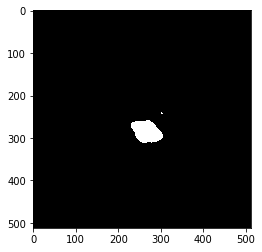

In [ ]:
prrr = predict[0][1].numpy()
threshold = -5
for r in range(512):
    for l in range(512):
        if prrr[r][l] >= threshold:
            prrr[r][l] = 255
        else:
            prrr[r][l] = 0
plt.imshow(prrr, cmap='gray')

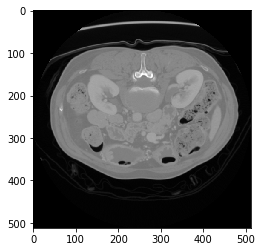

In [ ]:
plt.imshow(image[0][1],'gray')